In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from scipy import interpolate

In [2]:
df = pd.read_csv("jpmc_data.csv")
df.head(), df.shape
# df

(         Date       Price
 0  10/31/2020  520.349403
 1  11/30/2020  524.764215
 2  12/31/2020  574.740259
 3   1/31/2021  602.355246
 4   2/28/2021  593.415544,
 (48, 2))

<br>
<br>

# Part1 : Interpolation and Extrapolation of Natural Gas Prices

### slides : 20 - 31

<Figure size 432x288 with 0 Axes>

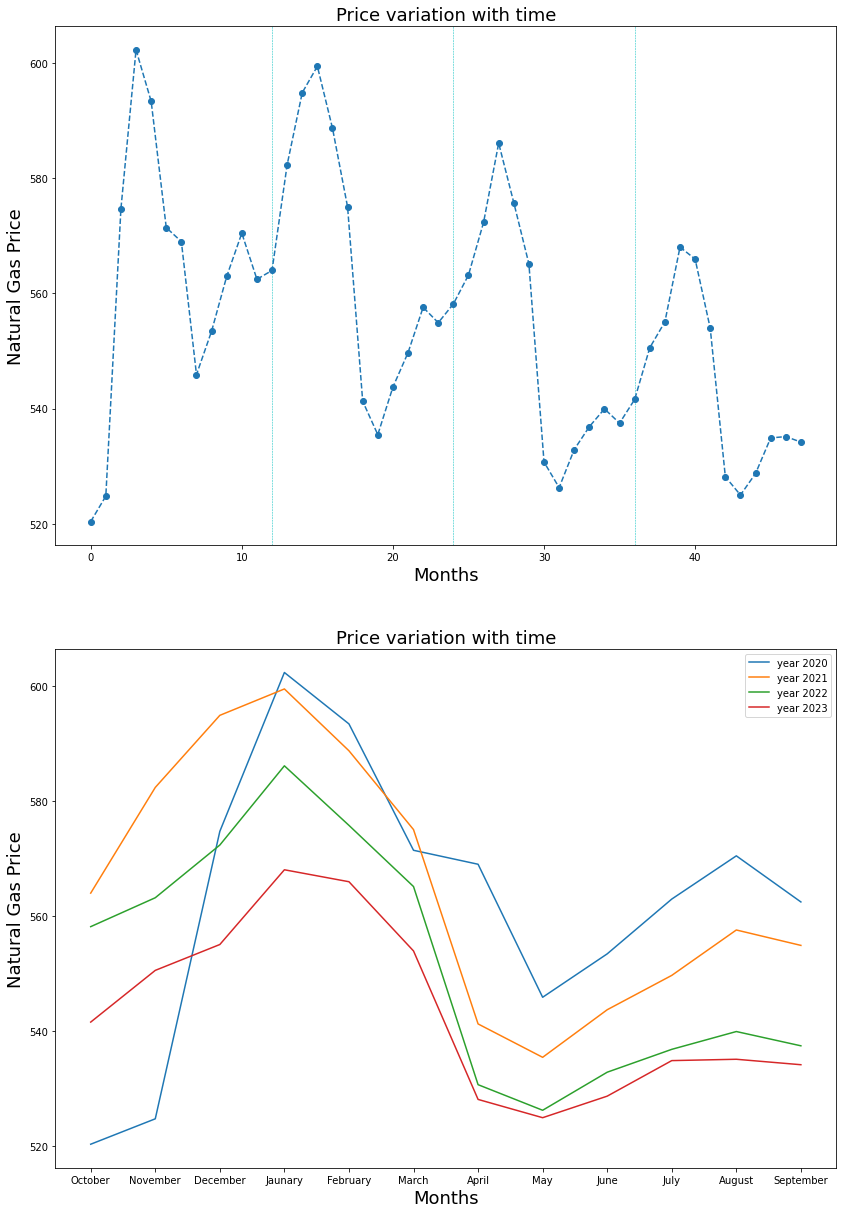

In [3]:
#visualising the data
plt.clf()
months = [
    "October",
    "November",
    "December",
    "Jaunary",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "September"
]

y = (df['Price'].to_numpy())
fig, axs = plt.subplots(2, 1, figsize = (14,21))

xposition = [12, 24, 36]
for xc in xposition:
    axs[0].axvline(x=xc, color='c', linestyle='--', linewidth=0.5)
    
for i in range(2):
    axs[i].set_xlabel("Months", fontsize = 18)
    axs[i].set_ylabel("Natural Gas Price", fontsize = 18)
    axs[i].set_title("Price variation with time", fontsize = 18)

axs[0].plot(y, 'o--')
# axs[0].scatter(list(range(y.shape[0])), y)

for i in range(4):
    axs[1].plot(months, y[12*i: 12*i + 12], label = "year {}".format(2020 + i))

plt.legend()
plt.show()

In [4]:
#the most basic model
#convert the date into a usable form

hinge_date = "2020-10-31" #YYYY-MM-DD
#convert the date into the how many days have passed since 1st january 2020
def preprocess_date(s, hinge = hinge_date ):
    other = datetime.strptime(hinge_date, "%Y-%m-%d")
    current = datetime.strptime(s, "%Y-%m-%d")
    days = (current - other).days
    return days, days%365, days//365

# preprocess_date("2025-09-01")
def fix_format(s):
    return datetime.strptime(s, '%m/%d/%Y').strftime( '%Y-%m-%d')


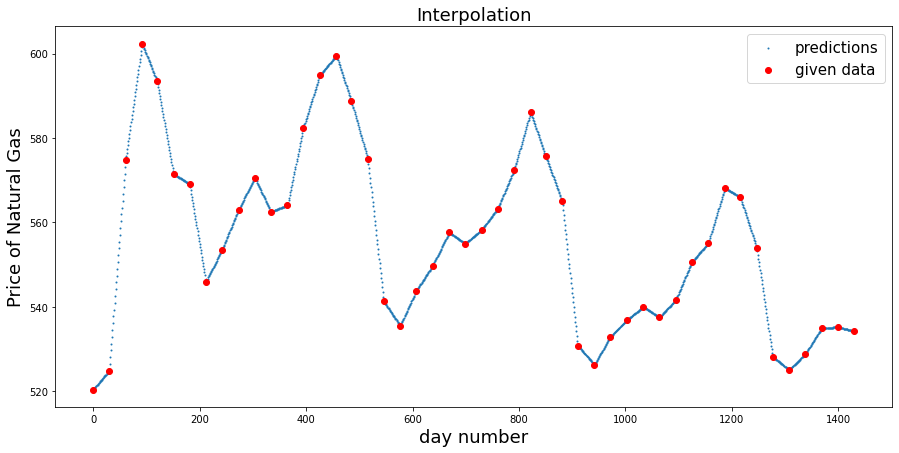

In [5]:
x = df['Date'].to_numpy()
x = [fix_format(s) for s in x]
x_partial = [preprocess_date(s)[0] for s in x[:12]]
x_partial
x = [preprocess_date(s)[0] for s in x]

last_known = "2024-09-30"
last_known_day = preprocess_date(last_known)[0]
def predict(day, x, y, maxi):
    if day <= maxi:
        #interpolate
#         print(x,y)
        return np.interp(day, x, y)
    else:
        #consider 4 years
        #extrapolate
        rem = day%365
        ans = np.sum([(np.interp(rem + i*365, x, y))*(((i+1)**2)/30) for i in range(4)] )
        return ans
    
all_xs = list(range(last_known_day))
# all_xs
ys = [predict(a, x, y, last_known_day) for a in (all_xs)]
plt.figure(figsize=(15,7))
plt.scatter(all_xs, ys, label = 'predictions', s = 1)
plt.scatter(x, y, color = "red", label = 'given data')
plt.xlabel("day number", fontsize=18)
plt.ylabel("Price of Natural Gas", fontsize=18)
plt.title("Interpolation", fontsize=18)
plt.legend(prop={'size': 15})
plt.show()

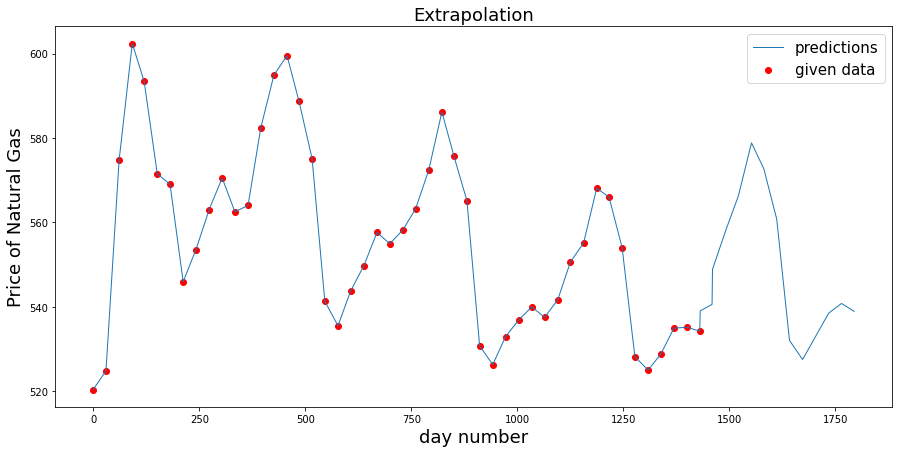

In [6]:
last_known = "2024-09-30"
last_known_day = preprocess_date(last_known)[0]

all_xs = list(range(last_known_day + 365))
ys = [predict(a, x, y, last_known_day) for a in (all_xs)]
from scipy import interpolate
plt.figure(figsize=(15,7))
plt.plot(all_xs, ys, label = 'predictions', linewidth = 1)
plt.scatter(x, y, color = "red", label = 'given data')
plt.xlabel("day number", fontsize=18)
plt.ylabel("Price of Natural Gas", fontsize=18)
plt.title("Extrapolation", fontsize=18)
plt.legend(prop={'size': 15})
plt.show()

<Figure size 432x288 with 0 Axes>

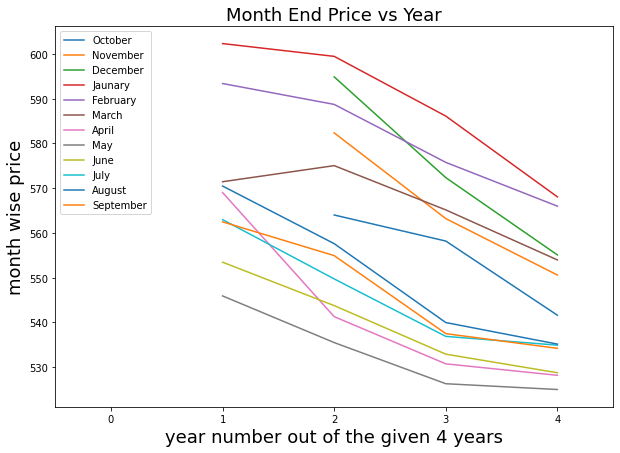

In [7]:
# visualising the general trend : overall decline in price over years

plt.clf()
plt.figure(figsize=(10,7))
invalid = set([0,1,2])
do_invalid = True



y_extended = y.tolist()
pending = []
for i in range(12):
    if i in invalid:
        x_axis = [i+12*j for j in range(1,4)]
        plt.plot([2,3,4],[y[ind] for ind in x_axis], label = months[i])
        reg = LinearRegression().fit(np.array([2,3,4]).reshape(-1, 1), [y[ind] for ind in x_axis])
        pending.append(reg.predict(np.array([5, 6, 7, 8, 9]).reshape(-1,1)).tolist())
        
    else:
        x_axis = [i+12*j for j in range(4)]
        plt.plot([1,2,3,4],[y[ind] for ind in x_axis], label = months[i])
        reg = LinearRegression().fit(np.array([1,2,3,4]).reshape(-1, 1), [y[ind] for ind in x_axis])
        pending.append(reg.predict(np.array([5, 6, 7, 8, 9]).reshape(-1,1)).tolist())
        
for j in range(5):
    for p in pending:
        y_extended.append(p[j])

# for i in range(12):
#     if i in invalid and do_invalid:
#         x_axis = [i+12*j for j in range(1,4)]
#         plt.plot([2,3,4],[y[ind] for ind in x_axis], label = months[i])
        
#     else:
#         x_axis = [i+12*j for j in range(4)]
#         plt.plot([1,2,3,4],[y[ind] for ind in x_axis], label = months[i])
#         if not do_invalid and i in invalid:
#             plt.scatter([1], [y[x_axis[0]]], c = "k", marker = "X")

plt.xlim(-0.5,4.5)
plt.legend(loc = "best")
plt.xlabel("year number out of the given 4 years", fontsize = 18)
plt.ylabel("month wise price", fontsize = 18)
plt.title("Month End Price vs Year", fontsize = 18)
plt.show()

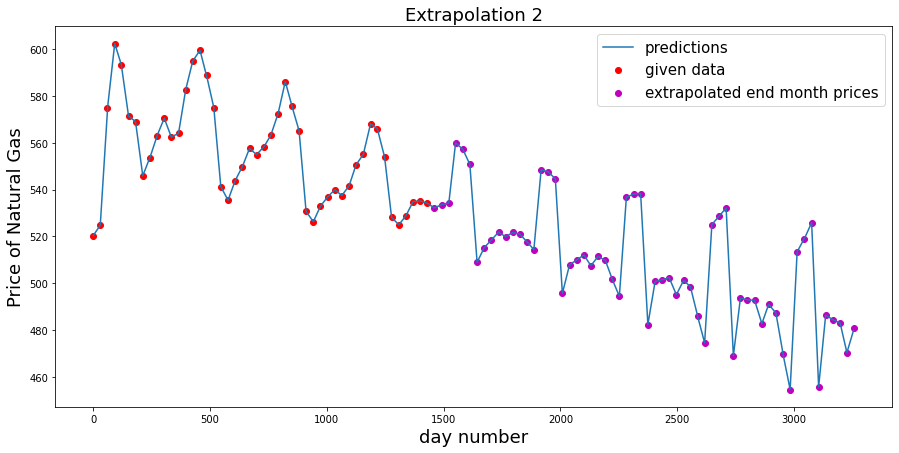

In [8]:
last_known = "2024-09-30"
last_known_day = preprocess_date(last_known)[0]
    
x_extended = x.copy()
for _ in range(60):
    x_extended.append(x_extended[-11] - x_extended[-12] + x_extended[-1])
all_xs = list(range(last_known_day + 5*365))

f = interpolate.interp1d(x_extended, y_extended, kind='linear')
ys = [f(a) for a in (all_xs)]
plt.figure(figsize=(15,7))
plt.plot(all_xs, ys, label = 'predictions')
plt.scatter(x, y, color = "red", label = 'given data')
plt.scatter(x_extended[48:], y_extended[48:], color = "m", label = 'extrapolated end month prices')
plt.xlabel("day number", fontsize=18)
plt.ylabel("Price of Natural Gas", fontsize=18)
plt.title("Extrapolation 2", fontsize=18)
plt.legend(prop={'size': 15})
plt.show()

<br>
<br>

# Part4 : Estimating a contract with known future prices

### slides : 3 - 10

In [9]:
def fix_format(s):
    return datetime.strptime(s, '%m/%d/%Y').strftime( '%Y-%m-%d')


def evaluate(pattern, day_nums, cost_per_day_stored, prices, storage_cap, delta, penalty):
	#evaluates a buying selling pattern
	#delta is the amt that can be sold or added in a day
	current_store = 0
	ans = 0
	for i in range(len(pattern)):
		if i > 0:
			num_days_in_bw = day_nums[i] - day_nums[i-1]
			ans -= (current_store*delta)*cost_per_day_stored*num_days_in_bw

			if current_store*delta >= storage_cap:
				ans -= (current_store*delta - storage_cap)*penalty*num_days_in_bw
				# ans -= (current_store*delta)*penalty*num_days_in_bw

		if pattern[i] == 1:
			#buying
			ans -= delta*prices[i]
			current_store += 1 

		elif pattern[i] == -1:
			if current_store == 0:
				#implies store is empty
				return -10**15
			else:
				#selling is possible
				ans += delta*prices[i]
				current_store -= 1
		else:
			#do nothing
			pass
	# if ans > 133:
	# 	print(pattern)
	return round(ans, 5), pattern.copy()



def recursion(pattern, day_nums, cost_per_day_stored, prices, storage_cap, delta, penalty, to_set = 0, return_pattern= False):
    patt = None
    best_pattern = None
    if to_set == len(pattern):
        ans =  evaluate(pattern, day_nums, cost_per_day_stored, prices, storage_cap, delta, penalty)
        if return_pattern:
            return ans
        else:
            return ans[0]
    else:
        best = 0
        if sum(pattern[:to_set]) == 0:
            possible = [0,1]
        else:
            possible = [-1, 0, 1]

        for i in possible:

            pattern[to_set] = i
            temp = pattern.copy()
            if return_pattern:
                pot, patt = recursion(pattern, day_nums, cost_per_day_stored, prices, storage_cap, delta, penalty, to_set +1, return_pattern)
            else:
                pot = recursion(pattern, day_nums, cost_per_day_stored, prices, storage_cap, delta, penalty, to_set +1, return_pattern)
            
#             print(best, pot)
            new_best = max(best, pot )
            if new_best > best:
                best = new_best
#                 print(temp, best)
                best_pattern = patt
                
        if return_pattern:
            return best, best_pattern
        return best

In [10]:
# default test case for q4 
input1 = 6
input2 = ["2020-10-1","2020-11-1", "2020-12-1", "2021-1-1", "2021-2-1", "2021-3-1"]
input3 = [2.135, 3.654, 2.921, 5.445, 6.312, 4.214]
input4 = 20
input5 = 0.0003
input6 = 100
input7 = 0.00005

# given test case
# input1 = 4
# input2 = ['2020-11-1', '2020-12-1', '2021-1-1', '2021-2-1']
# input3 = [2.645, 1.992, 4.25, 1.916]
# input4 = 6
# input5 = 0.00052
# input6 = 30
# input7 = 0.00008

day_nums = [preprocess_date(s)[0] for s in input2]
cost_per_day_stored = input5
penalty = input7 #not sure whehter applied on all or just the excess
# L = input1
L = len(input3)
prices = input3
delta = input4
storage_cap = input6
pattern = [-1 for i in range(L)]

In [11]:
# running on the given test case
ans = recursion(pattern, day_nums, cost_per_day_stored, prices, storage_cap, delta, penalty, return_pattern = True)

print(ans)

(143.576, [1, 1, 1, -1, -1, -1])


<Figure size 432x288 with 0 Axes>

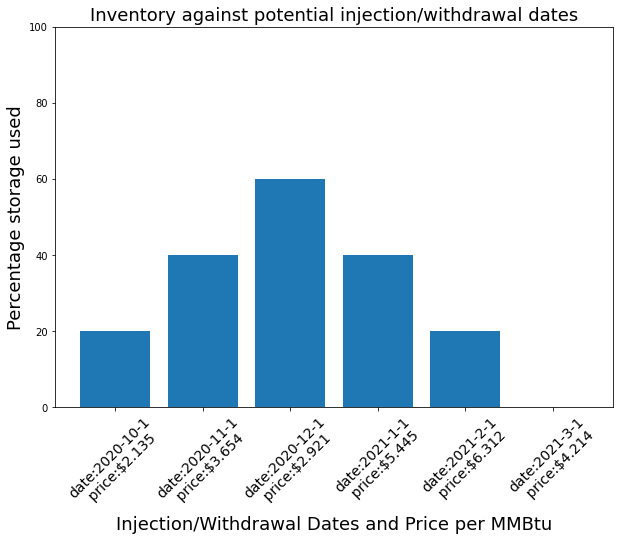

In [12]:
_, patt = recursion( [-1 for i in range(L)], day_nums, cost_per_day_stored, prices, storage_cap, delta, penalty, return_pattern = True)
# print(patt)
vols = [0]
for p in patt:
    vols.append(vols[-1] + p)
vols = vols[1:]
vols = [round((v*100)*delta/storage_cap, 5) for v in vols]

plt.clf()
plt.figure(figsize=(10,7))
# plt.plot(input2, [0, 20, 0, 0])
x_axis = ["date:{}\n price:${}".format(d, p) for d,p in zip(input2, prices) ]
plt.bar(x_axis, vols)
plt.title("Inventory against potential injection/withdrawal dates", fontsize = 18 )
plt.xlabel("Injection/Withdrawal Dates and Price per MMBtu", fontsize = 18)
plt.ylabel("Percentage storage used", fontsize = 18)
plt.ylim(0,100)
plt.xticks(rotation=45, size = 14) # rotate x-axis labels by 45 degrees.
# yticks(rotation=90) # rotate y-axis labels by 90 degrees.
# plt.ylabel()
plt.show()

<br>
<br>
<br>

# Part 5: Evaluating a contract under uncertainty

### slides 11 - 19

100%|██████████| 30000/30000 [00:22<00:00, 1336.79it/s]


[2.2, 2.73804, 2.312626, 3.325111]


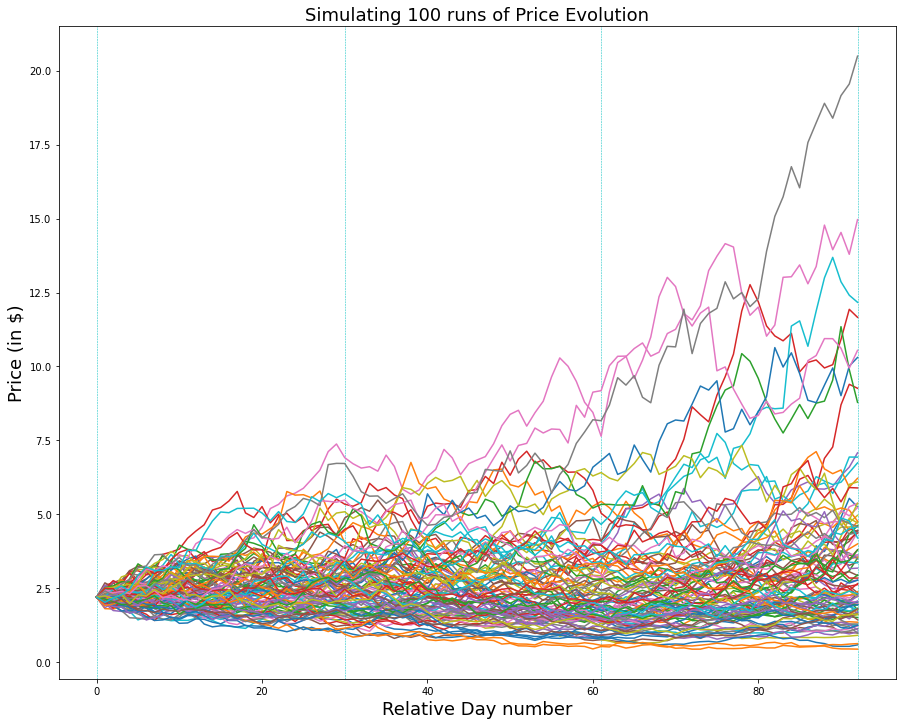

In [13]:
# for q5
input1 = 4
input2 = ['2020-11-1', '2020-12-1', '2021-1-1', '2021-2-1']
input3 = [2.645, -1.992, 4.25, -1.916]
input4 = 0.0052
input5 = 1.4
input6 = 2.2
input7 = 30000
input8 = 32

cost_per_day_stored = input5
L = len(input3)
prices = input3
delta = input4
storage_cap = input6
pattern = [-1 for i in range(L)]
penalty = input7 #not sure whehter applied on all or just the excess
L = input1
day_nums = [preprocess_date(s)[0] for s in input2]
day_nums = [d - day_nums[0] for d in day_nums]

mus = input3
per_day = input4
sigma = input5
s0 = input6
K = input7
multi = 1e6* input8

all_mus = []
for i in range(len(day_nums) -1):
	for _ in range(day_nums[i+1] - day_nums[i]):
		all_mus.append(mus[i])

num_days = day_nums[-1] - day_nums[0]

sims = []
dt = 1/365

plt.figure(figsize=(15,12))
for d in day_nums:
    plt.axvline(x=d, color='c', linestyle='--', linewidth=0.5)
    
num = 100

indices = {d:i for i,d in enumerate(day_nums)}
price_sum = [0 for _ in (day_nums)]
temp = []
for counter in tqdm(range(K)):
    current = []
    current.append(s0)
    price_sum[0]+=(s0)
    for day in range(num_days):
        mu = all_mus[day]
        x = np.exp((mu - (sigma ** 2 / 2)) * dt + sigma * np.random.normal(0, np.sqrt(dt)))
        current.append(current[-1]*x)
        
        if day+1 in day_nums:
            if day+1 == day_nums[1]:
                temp.append(current[-1])
            price_sum[indices[day+1]] += current[-1]
            
    if counter < num:
        plt.plot(current)


prices = [round(p/K,6 )for p in price_sum]
print(prices)
plt.title("Simulating {} runs of Price Evolution".format(num), fontsize = 18)
plt.ylabel("Price (in $)", fontsize = 18)
plt.xlabel("Relative Day number", fontsize = 18)    
plt.show()

<Figure size 432x288 with 0 Axes>

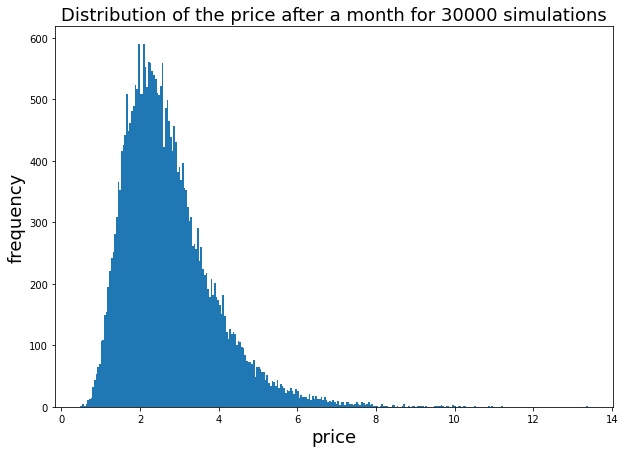

In [14]:
# Distribution of price after a month

plt.clf()
plt.figure(figsize = (10,7))
plt.xlabel("price", fontsize = 18)
plt.ylabel("frequency", fontsize = 18)
plt.title("Distribution of the price after a month for {} simulations".format(K), fontsize = 18)
plt.hist(temp, bins = 300)
plt.show()



In [15]:
# fidning the best contract for q5
# can use Kandanes algo to make it faster
ans = 0
for i in range(L):
    for j in range(i+1, L):
        pot = (prices[j] - prices[i])*multi - (day_nums[j] - day_nums[i])*cost_per_day_stored
        ans = max(ans, pot)
print(ans/1e6)

36.0034232


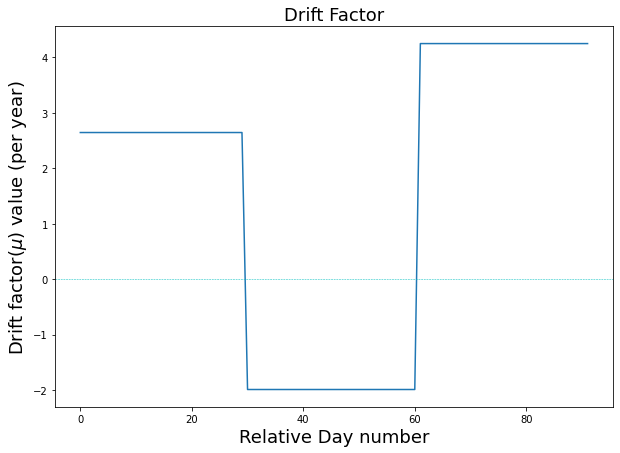

In [16]:
plt.figure(figsize=(10,7))
plt.plot(all_mus)
plt.ylabel("Drift factor($\mu$) value (per year)", fontsize = 18)
plt.xlabel("Relative Day number", fontsize = 18)
plt.title("Drift Factor", fontsize = 18)
plt.axhline(y=0, color='c', linestyle='--', linewidth=0.5)
plt.show()